,Method,Preprocessing,Clusters,Silhouette,Calinski-Harabasz,Davies-Bouldin
0,KMeans,No Preprocessing,3,0.571,562,0.53
1,KMeans,No Preprocessing,4,0.545,600,0.56
2,KMeans,No Preprocessing,5,0.548,727,0.54
3,KMeans,Normalization,3,0.285,71,1.39
4,KMeans,Normalization,4,0.286,54,1.49
5,KMeans,Normalization,5,0.245,46,1.69
6,KMeans,Transform,3,0.301,73,1.36
7,KMeans,Transform,4,0.236,53,1.71
8,KMeans,Transform,5,0.210,46,1.96
9,KMeans,PCA,3,0.572,563,0.53


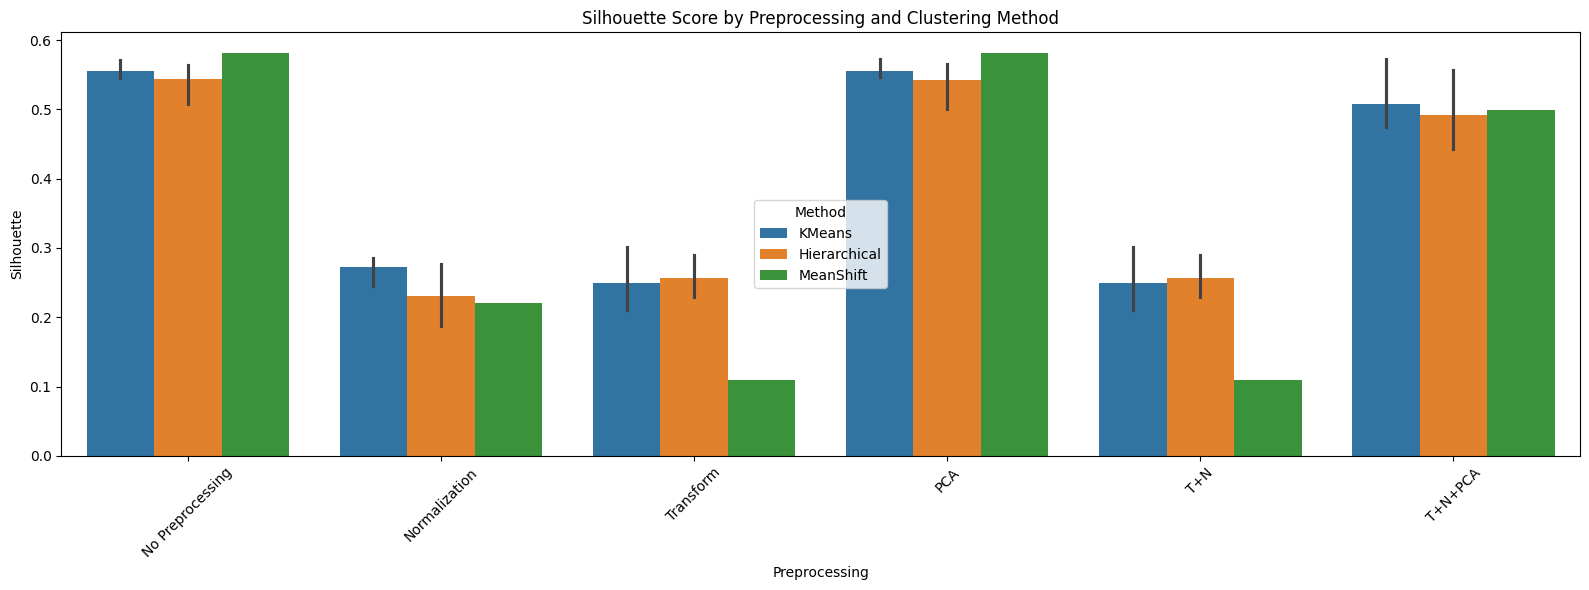

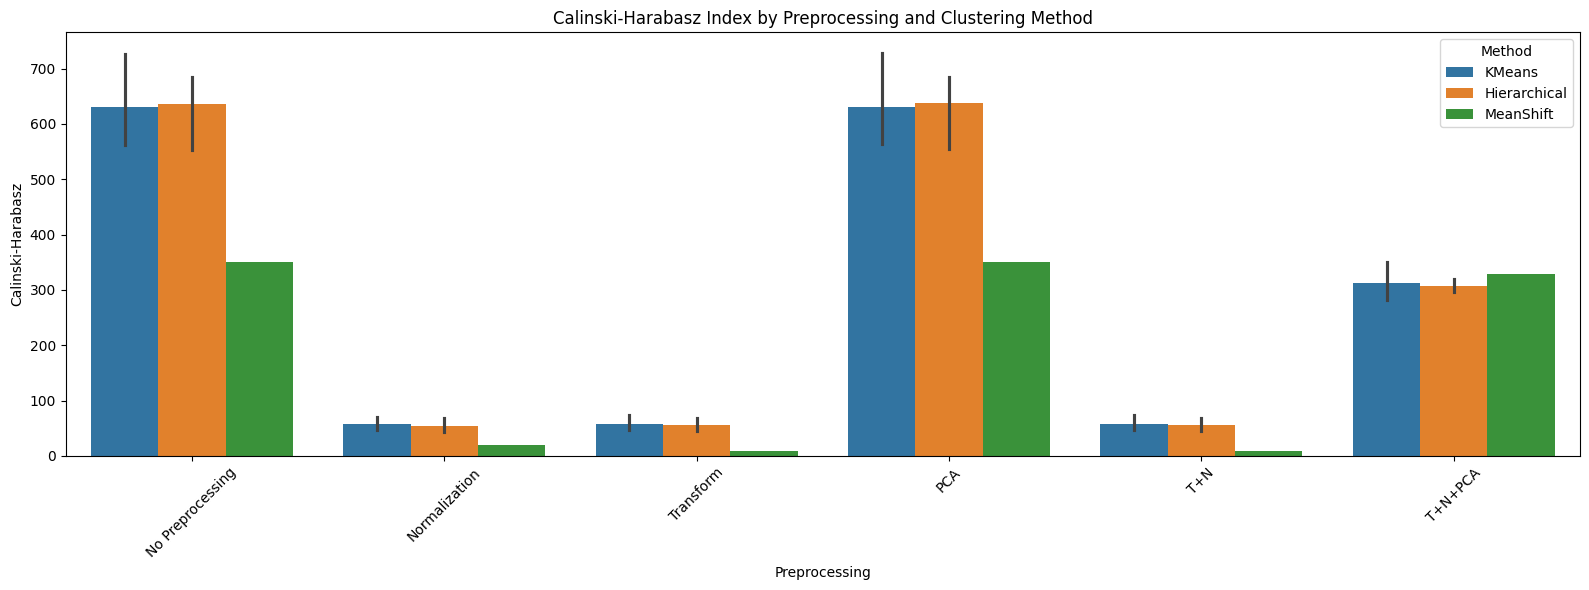

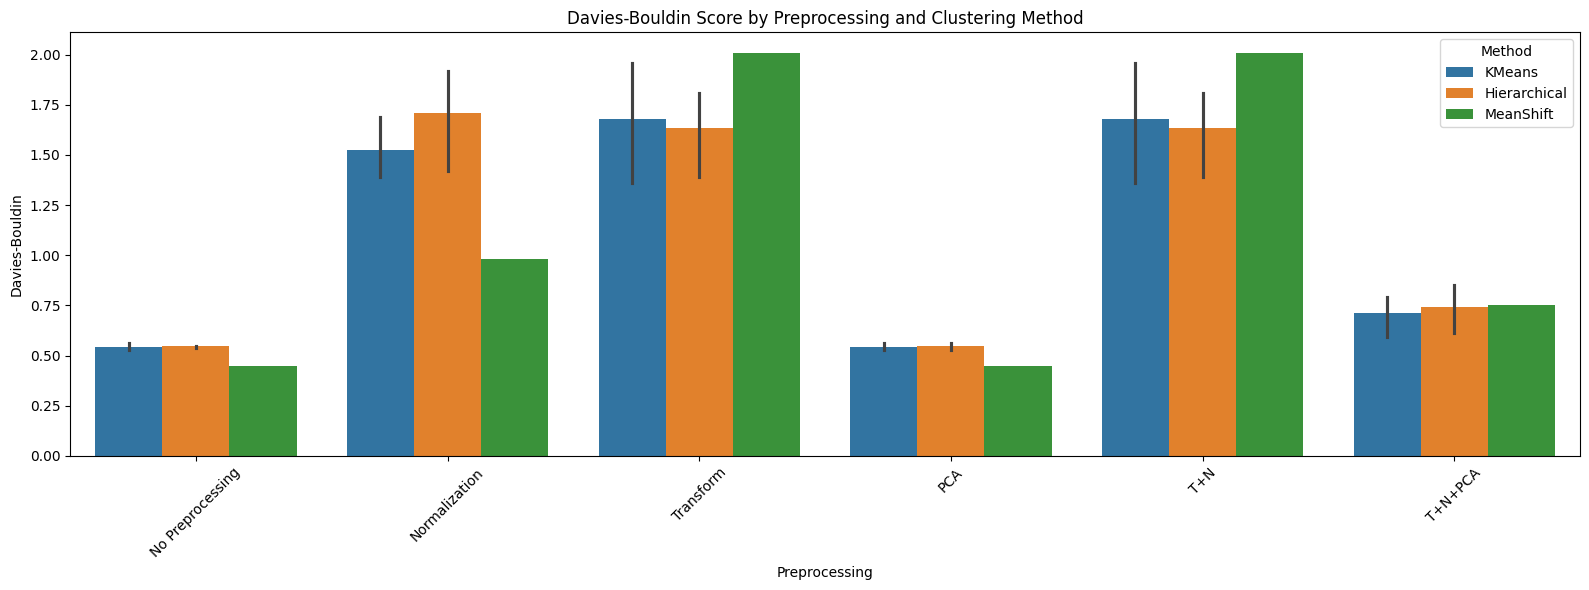

In [ ]:
# Wine Dataset Clustering Analysis (UCI)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import warnings
warnings.filterwarnings('ignore')

# Load Wine Dataset
wine = load_wine()
X = pd.DataFrame(wine.data, columns=wine.feature_names)

# Functions for clustering and evaluation
def evaluate_clustering(X, labels):
    sil = silhouette_score(X, labels)
    ch = calinski_harabasz_score(X, labels)
    db = davies_bouldin_score(X, labels)
    return sil, ch, db

# Preprocessing functions
def apply_preprocessing(X, norm=False, transform=False, pca=False, n_components=2):
    X_proc = X.copy()
    if transform:
        pt = PowerTransformer()
        X_proc = pt.fit_transform(X_proc)
    if norm:
        scaler = StandardScaler()
        X_proc = scaler.fit_transform(X_proc)
    if pca:
        pca_obj = PCA(n_components=n_components)
        X_proc = pca_obj.fit_transform(X_proc)
    return X_proc

# Clustering configurations
cluster_counts = [3, 4, 5]
preprocessing_configs = {
    "No Preprocessing": {},
    "Normalization": {"norm": True},
    "Transform": {"transform": True},
    "PCA": {"pca": True},
    "T+N": {"transform": True, "norm": True},
    "T+N+PCA": {"transform": True, "norm": True, "pca": True},
}

# Initialize results dictionary
results = {"KMeans": {}, "Hierarchical": {}, "MeanShift": {}}

# KMeans & Hierarchical clustering
for method in ["KMeans", "Hierarchical"]:
    for preproc_name, preproc_params in preprocessing_configs.items():
        for c in cluster_counts:
            X_proc = apply_preprocessing(X, **preproc_params)
            if method == "KMeans":
                model = KMeans(n_clusters=c, random_state=0)
            else:
                model = AgglomerativeClustering(n_clusters=c)
            labels = model.fit_predict(X_proc)
            sil, ch, db = evaluate_clustering(X_proc, labels)
            results[method][(preproc_name, c)] = (round(sil, 3), round(ch), round(db, 2))

# Mean Shift Clustering (no cluster count required)
for preproc_name, preproc_params in preprocessing_configs.items():
    X_proc = apply_preprocessing(X, **preproc_params)
    bandwidth = estimate_bandwidth(X_proc, quantile=0.2)
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    labels = ms.fit_predict(X_proc)
    c = len(np.unique(labels))
    sil, ch, db = evaluate_clustering(X_proc, labels)
    results["MeanShift"][(preproc_name, c)] = (round(sil, 3), round(ch), round(db, 2))

# Convert results to DataFrame
all_rows = []
for method, method_results in results.items():
    for (prep, c), (sil, ch, db) in method_results.items():
        all_rows.append([method, prep, c, sil, ch, db])

df_results = pd.DataFrame(all_rows, columns=["Method", "Preprocessing", "Clusters", "Silhouette", "Calinski-Harabasz", "Davies-Bouldin"])

# Display table
pd.set_option('display.max_rows', None)
display(df_results)

# Visualization
plt.figure(figsize=(16, 6))
sns.barplot(data=df_results, x="Preprocessing", y="Silhouette", hue="Method")
plt.title("Silhouette Score by Preprocessing and Clustering Method")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 6))
sns.barplot(data=df_results, x="Preprocessing", y="Calinski-Harabasz", hue="Method")
plt.title("Calinski-Harabasz Index by Preprocessing and Clustering Method")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 6))
sns.barplot(data=df_results, x="Preprocessing", y="Davies-Bouldin", hue="Method")
plt.title("Davies-Bouldin Score by Preprocessing and Clustering Method")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


,Method,Preprocessing,Clusters,Silhouette,Calinski-Harabasz,Davies-Bouldin
0,KMeans,No Preprocessing,3,0.571,562,0.53
1,KMeans,No Preprocessing,4,0.545,600,0.56
2,KMeans,No Preprocessing,5,0.548,727,0.54
3,KMeans,Normalization,3,0.285,71,1.39
4,KMeans,Normalization,4,0.286,54,1.49
5,KMeans,Normalization,5,0.245,46,1.69
6,KMeans,Transform,3,0.301,73,1.36
7,KMeans,Transform,4,0.236,53,1.71
8,KMeans,Transform,5,0.210,46,1.96
9,KMeans,PCA,3,0.572,563,0.53


Mounted at /content/drive


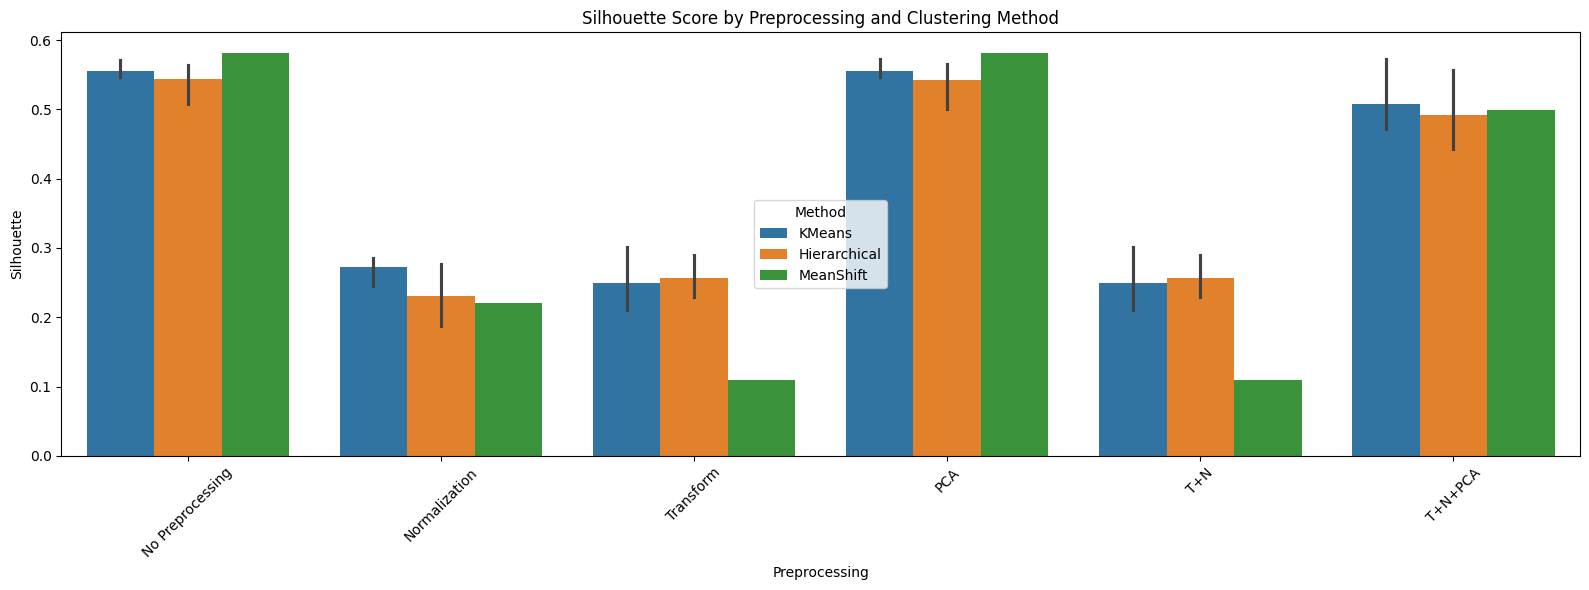

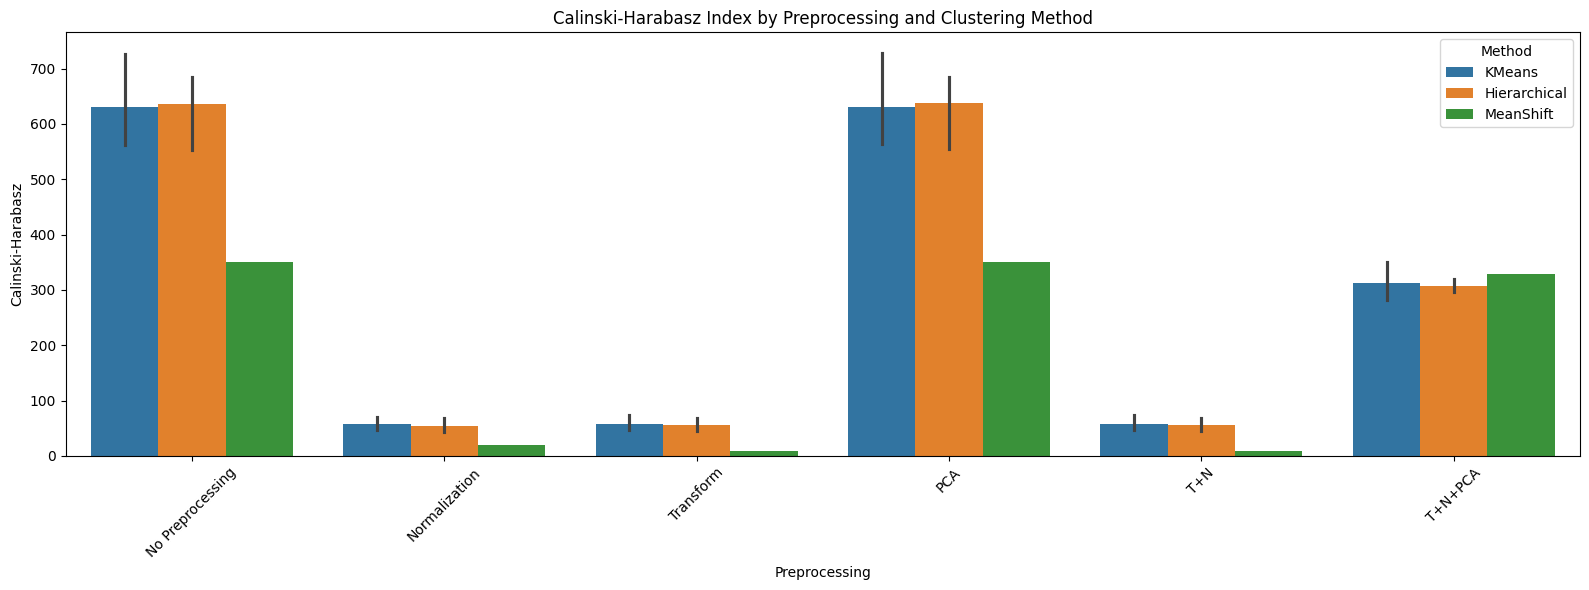

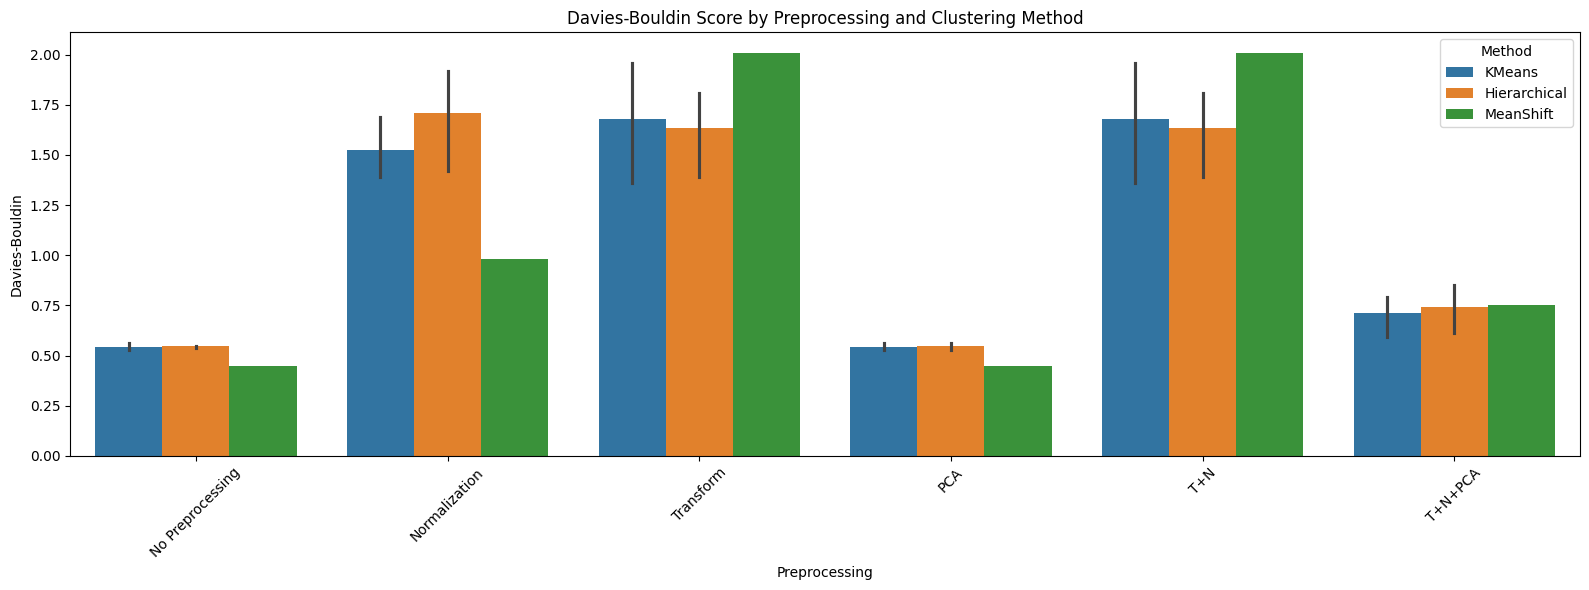

In [ ]:
# Wine Dataset Clustering Analysis (UCI)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import warnings
warnings.filterwarnings('ignore')

# Load Wine Dataset
wine = load_wine()
X = pd.DataFrame(wine.data, columns=wine.feature_names)

# Functions for clustering and evaluation
def evaluate_clustering(X, labels):
    sil = silhouette_score(X, labels)
    ch = calinski_harabasz_score(X, labels)
    db = davies_bouldin_score(X, labels)
    return sil, ch, db

# Preprocessing function
def apply_preprocessing(X, norm=False, transform=False, pca=False, n_components=2):
    X_proc = X.copy()
    if transform:
        pt = PowerTransformer()
        X_proc = pt.fit_transform(X_proc)
    if norm:
        scaler = StandardScaler()
        X_proc = scaler.fit_transform(X_proc)
    if pca:
        pca_obj = PCA(n_components=n_components)
        X_proc = pca_obj.fit_transform(X_proc)
    return X_proc

# Configurations
cluster_counts = [3, 4, 5]
preprocessing_configs = {
    "No Preprocessing": {},
    "Normalization": {"norm": True},
    "Transform": {"transform": True},
    "PCA": {"pca": True},
    "T+N": {"transform": True, "norm": True},
    "T+N+PCA": {"transform": True, "norm": True, "pca": True},
}

# Initialize results list
results = []

# KMeans & Hierarchical Clustering
for method in ["KMeans", "Hierarchical"]:
    for preproc_name, preproc_params in preprocessing_configs.items():
        for c in cluster_counts:
            X_proc = apply_preprocessing(X, **preproc_params)
            if method == "KMeans":
                model = KMeans(n_clusters=c, random_state=0)
            else:
                model = AgglomerativeClustering(n_clusters=c)
            labels = model.fit_predict(X_proc)
            sil, ch, db = evaluate_clustering(X_proc, labels)
            results.append({
                "Method": method,
                "Preprocessing": preproc_name,
                "Clusters": c,
                "Silhouette": round(sil, 3),
                "Calinski-Harabasz": round(ch),
                "Davies-Bouldin": round(db, 2)
            })

# Mean Shift Clustering
for preproc_name, preproc_params in preprocessing_configs.items():
    X_proc = apply_preprocessing(X, **preproc_params)
    bandwidth = estimate_bandwidth(X_proc, quantile=0.2)
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    labels = ms.fit_predict(X_proc)
    c = len(np.unique(labels))
    sil, ch, db = evaluate_clustering(X_proc, labels)
    results.append({
        "Method": "MeanShift",
        "Preprocessing": preproc_name,
        "Clusters": c,
        "Silhouette": round(sil, 3),
        "Calinski-Harabasz": round(ch),
        "Davies-Bouldin": round(db, 2)
    })

# Convert to DataFrame
df_results = pd.DataFrame(results)

# Display results table
pd.set_option('display.max_rows', None)
display(df_results)

# Save to CSV (in Colab runtime)
df_results.to_csv("wine_clustering_results.csv", index=False)

# OPTIONAL: Save to Google Drive
from google.colab import drive
drive.mount('/content/drive')
df_results.to_csv('/content/drive/My Drive/wine_clustering_results.csv', index=False)

# Visualizations
plt.figure(figsize=(16, 6))
sns.barplot(data=df_results, x="Preprocessing", y="Silhouette", hue="Method")
plt.title("Silhouette Score by Preprocessing and Clustering Method")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 6))
sns.barplot(data=df_results, x="Preprocessing", y="Calinski-Harabasz", hue="Method")
plt.title("Calinski-Harabasz Index by Preprocessing and Clustering Method")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 6))
sns.barplot(data=df_results, x="Preprocessing", y="Davies-Bouldin", hue="Method")
plt.title("Davies-Bouldin Score by Preprocessing and Clustering Method")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
